# Agregaremos mas datos para reentrenar nuestro modelo:

### 1.Agregamos mas datos de Operacion KUNTOR

In [1]:
#Librerias que se usaran
import pandas as pd  # Libreria para administrar tablas, y realizar trabajos con distintas formas de tablas o dataframes
import numpy as np   # Libreria para poder hacer operaciones matematicas y matriciales
import matplotlib.pyplot as plt # Libreria para realizar graficos 
from tabulate import tabulate   # Permite formatear y mostrar de mejor manera los datos tabulares
import seaborn as sns  # Libreria para realizar graficos y vizualizaciones
import psycopg2        # Libreria que permite la conexion con PostgresSQL
from matplotlib.backends.backend_pdf import PdfPages # Libreria que permite exportar graficos en pdf

Establecemos la conexion con el servidor de Azure, y extraemos datos de Posgresql, que utilizaremos en el analisis

In [23]:
# Información de la conexión a PostgreSQL
host = "kumtorcontrolsensedb.postgres.database.azure.com"
database = "ControlSenseDB"
user = "postgres"
password = "Larc0mar"

# Establecer la conexión a la base de datos
try:
    connection = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )

    # Crear un cursor para ejecutar comandos SQL
    cursor = connection.cursor()

    # Establecer la zona horaria antes de ejecutar la consulta
    time_zone_query = "SET TIME ZONE 'Asia/Bishkek';"
    cursor.execute(time_zone_query)

    # Tu consulta SQL
    tu_query_sql = '''
select * from (select ff.capacidad_en_volumen_equipo_carguio_m3, ff.capacidad_en_peso_equipo_carguio, f.capacidad_pes capacidad_en_peso_equipo_acarreo,
a.tonelajevimsretain tonelaje_camion_antes_cargaestabilizada, t.angulo_giro_promedio angulo_giro_promedio_pases, o.densidad densidad_inicial_poligono_creado,
t.coord_x coord_x_pases,			   			   
ROW_NUMBER() OVER (PARTITION BY a.id ORDER BY a.id DESC) AS RowNum

from public.tp_cargadescarga a
left join (
SELECT tp.id id_ciclo_carguio, tp.id_palas, tp.id_equipo as id_equipo_carguio, 
tp.id_locacion, 
tp.id_poligono, tp.id_trabajador, tp.id_crew, tp.isspot, tp.bool_estado, tp.bool_equipo_next, tp.cola, 
tcd1.tiem_carga as tiempo_inicio_carga_carguio,
tcd1.tiem_acarreo as tiempo_esperando_carguio,
getreadytime( tp.id_equipo, tcd1.tiem_carga, tcd1.tiem_acarreo) tiempo_ready_cargando,
getreadytime( tp.id_equipo, 
			 lag(tcd1.tiem_acarreo) OVER (PARTITION BY (COALESCE(null, true)), tp.id_equipo ORDER BY tcd1.tiem_carga), 
			 tcd1.tiem_carga) tiempo_ready_esperando,
lag(tcd1.tiem_acarreo) OVER (PARTITION BY (COALESCE(null, true)), tp.id_equipo ORDER BY tcd1.tiem_carga) AS previous_esperando_pala,
tcd1.tiem_acarreo,
tcd1.tiem_carga
FROM tp_cargadescarga tcd1
LEFT JOIN tp_palas tp ON tp.id = (SELECT id 
						  FROM tp_palas 
						 	WHERE id_palas = tcd1.id_palas
						 	ORDER BY ID DESC LIMIT 1)
WHERE tcd1.tiem_elimin IS NULL
AND tcd1.tiem_viajando IS NOT NULL
and tp.tiem_elimin IS NULL and tcd1.tiem_carga > CAST('2023-01-01' AS DATE)) m
on a.id_palas = m.id_palas
				 
left join public.ts_poligono o
on m.id_poligono = o.id
				 
left join (select d.id_principal, c.id id_equipo,
c.capacidad_pes, c.capacidadtanque
from public.ts_equipos c
inner join (select b.id id_principal , b.nombre principal, a.id id_secundario , a.nombre secundario from public.ts_equipos a
inner join (select id, nombre from public.ts_equipos where id_flota = 0 and tiem_elimin is null) b
on b.id = a.id_flota
where a.tiem_elimin is null) d
on d.id_secundario = c.id_flota
where c.id_flota <> 0 and c.isflota = false and c.tiem_elimin is null
order by d.id_principal) f
on a.id_equipo = f.id_equipo

left join (select d.id_principal, c.capacidad_vol capacidad_en_volumen_equipo_carguio_m3, c.id id_equipo,
c.capacidad_pes capacidad_en_peso_equipo_carguio, c.radiohexagonocuchara radiohexagonocuchara_equipocarguio
from public.ts_equipos c
inner join (select b.id id_principal , b.nombre principal, a.id id_secundario , a.nombre secundario from public.ts_equipos a
inner join (select id, nombre from public.ts_equipos where id_flota = 0 and tiem_elimin is null) b
on b.id = a.id_flota
where a.tiem_elimin is null) d
on d.id_secundario = c.id_flota
where c.id_flota <> 0 and c.isflota = false and c.tiem_elimin is null
order by d.id_principal) ff
on m.id_equipo_carguio = ff.id_equipo

left join (select z.* from
    (select A.id, A.id_equipo,
    A.tiempo_estimado tiempo_estimado_duracion_estado, 
    ROW_NUMBER() OVER (PARTITION BY A.id_equipo ORDER BY A.id_equipo) AS row_num
    from public.tp_estados A
    left join public.ts_detal_estado B on A.id_detal_estado = B.id_detal_estado
    --left join (select * from public.ts_detal_estado where id=B.id_tipo_estad limit 1) C on true
    where A.tiem_elimin is null) z
    WHERE
    z.row_num = 1) ss
on m.id_equipo_carguio = ss.id_equipo

left join public.ts_locacion n
on m.id_locacion = n.id
left join (select * from public.ta_datacarga_sensores 
where tiem_elimin is NULL) t
on a.id_cargadescarga = t.id_cargadescarga
where a.tiem_elimin is null and a.tiem_llegada > CAST('2023-01-01' AS DATE)) z
where z.RowNum = 1
    '''

    # Ejecutar la consulta
    cursor.execute(tu_query_sql)

    # Obtener los resultados en un DataFrame de pandas
    resultados_datos = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

    # Cerrar el cursor y la conexión
    cursor.close()
    connection.close()

    # Hacer lo que necesites con los resultados
    print(resultados_datos.head())

except psycopg2.Error as e:
    print("Error al conectar a la base de datos PostgreSQL:", e)

In [2]:
#Configuramos pandas para que podamos vizualizar todas las columnas y filas la estadistica descriptiva de todas las variables
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
#Configuramos pandas para que lanze valores con una precision de hasta 6 decimales
pd.set_option('display.float_format', '{:.6f}'.format)
# Restaurar la configuración predeterminada
#pd.set_option('display.float_format', None) 

# Guardamos los datos extraidos de Azure

In [21]:
#Se guardaron los datos que fueron traidos de AZURE POSTGRESS
#resultados_df.to_csv('masdatos_modelo_opkuntor.csv', index=False)

In [16]:
datos = pd.read_csv('masdatos_modelo_opkuntor.csv')
datos.head()

,capacidad_en_volumen_equipo_carguio_m3,densidad_inicial_poligono_creado,angulo_giro_promedio_pases,coord_x_pases,rownum
0,23.000000,2.850000,NaN,NaN,1
1,23.000000,2.850000,NaN,NaN,1
2,NaN,NaN,60.000000,"[851757, 851809, 851615, 851572]",1
3,NaN,NaN,NaN,NaN,1
4,NaN,NaN,54.000000,"[759243, 759440, 759608]",1


### 2. Preprocesamiento de datos

Tratamiento de Valores Faltantes

In [17]:
# Columnas específicas en las que deseas eliminar las filas con nulos
columnas_a_verificar = ['angulo_giro_promedio_pases', 'coord_x_pases']

# Elimina las filas que contienen valores nulos en las columnas especificadas
datos = datos.dropna(subset=columnas_a_verificar)

# Rellenar los valores nulos con ceros en todo el DataFrame
datos = datos.fillna(0)

# Muestra la cantidad de valores nulos después de eliminar filas
print("\nValores nulos después de eliminar filas:")
print(datos.isnull().sum())


Valores nulos después de eliminar filas:
capacidad_en_volumen_equipo_carguio_m3    0
densidad_inicial_poligono_creado          0
angulo_giro_promedio_pases                0
coord_x_pases                             0
rownum                                    0
dtype: int64


Calculo de Nuevas variables

In [18]:
# Agregamos la variable calculada "numero_pases_carguio" basado en la columna 'coord_x_pases'
datos['numero_pases_carguio'] = datos['coord_x_pases'].apply(lambda x: len(eval(x)) if isinstance(x, str) and '[' in x else x if isinstance(x, int) else 0)

# Supongamos que 'datos' es tu DataFrame y 'columnas_a_eliminar' es una lista con los nombres de las columnas a eliminar
columnas_a_eliminar = ['coord_x_pases', 'rownum']

datos = datos.drop(columns=columnas_a_eliminar)

In [19]:
datos.head(90)

,capacidad_en_volumen_equipo_carguio_m3,densidad_inicial_poligono_creado,angulo_giro_promedio_pases,numero_pases_carguio
2,0.000000,0.000000,60.000000,4
4,0.000000,0.000000,54.000000,3
5,0.000000,0.000000,81.000000,4
8,0.000000,0.000000,48.000000,4
9,0.000000,0.000000,20.000000,6
10,0.000000,0.000000,31.000000,6
16,0.000000,0.000000,44.000000,5
18,0.000000,0.000000,0.000000,6
20,0.000000,0.000000,45.000000,5
21,0.000000,0.000000,0.000000,6


Tratamiento de Valores Outliers

In [20]:
Q1 = datos['numero_pases_carguio'].quantile(0.25)
Q3 = datos['numero_pases_carguio'].quantile(0.75)

# Calcular el rango intercuartilico (IQR)
IQR = Q3 - Q1

# Calcular los límites inferior y superior del bigote
Limite_inferior = round(Q1 - 1.5 * IQR)
Limite_superior = round(Q3 + 1.5 * IQR)

# Limitar los valores atípicos a los límites del bigote en la columna
datos['numero_pases_carguio'] = datos['numero_pases_carguio'].clip(lower=Limite_inferior, upper=Limite_superior)

In [21]:
Limite_inferior

1

In [22]:
Limite_superior

9

In [11]:
import pandas as pd

def limitar_valores_atipicos(df, nombre_columna):
    # Calcular Q1 y Q3 de la columna
    Q1 = df[nombre_columna].quantile(0.25)
    Q3 = df[nombre_columna].quantile(0.75)

    # Calcular el rango intercuartilico (IQR)
    IQR = Q3 - Q1

    # Calcular los límites inferior y superior del bigote
    limite_inferior = round(Q1 - 1.5 * IQR)
    limite_superior = round(Q3 + 1.5 * IQR)

    # Limitar los valores atípicos a los límites del bigote en la columna
    df[nombre_columna] = df[nombre_columna].clip(lower=limite_inferior, upper=limite_superior)

    return df

In [12]:
# Supongamos que 'datos' es tu DataFrame y 'numero_pases_carguio' es el nombre de la columna numérica
datos = limitar_valores_atipicos(datos, 'numero_pases_carguio')

In [13]:
datos.head(900)

,capacidad_en_volumen_equipo_carguio_m3,densidad_inicial_poligono_creado,angulo_giro_promedio_pases,numero_pases_carguio
2,0.000000,0.000000,60.000000,4
4,0.000000,0.000000,54.000000,3
5,0.000000,0.000000,81.000000,4
8,0.000000,0.000000,48.000000,4
9,0.000000,0.000000,20.000000,6
10,0.000000,0.000000,31.000000,6
16,0.000000,0.000000,44.000000,5
18,0.000000,0.000000,0.000000,6
20,0.000000,0.000000,45.000000,5
21,0.000000,0.000000,0.000000,6


In [ ]:
import pandas as pd

# Iterar a través de las columnas numéricas y limitar los valores atípicos
# Calcular el Q1 y Q3 de la columna
Q1 = datos['numero_pases_carguio'].quantile(0.25)
Q3 = datos['numero_pases_carguio'].quantile(0.75)

# Calcular el rango intercuartilico (IQR)
IQR = Q3 - Q1

# Calcular los límites inferior y superior del bigote
Limite_inferior = round(Q1 - 1.5 * IQR)
Limite_superior = round(Q3 + 1.5 * IQR)

# Limitar los valores atípicos a los límites del bigote en la columna
datos['numero_pases_carguio'] = datos['numero_pases_carguio'].clip(lower=Limite_inferior, upper=Limite_superior)

# Los valores atípicos en todas las variables (que no comienzan con 'id') están limitados a los límites del bigote

In [ ]:
# Concatenar los nuevos datos con los datos originales
datos_combinados = pd.concat([datos, nuevos_datos], axis=0)

Identificacion de Valores Duplicados

C:\Users\BryanInche-MS4M\AppData\Local\Temp\ipykernel_25844\631618845.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\BryanInche-MS4M\AppData\Local\Temp\ipykernel_25844\631618845.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\BryanInche-MS4M\AppData\Local\Temp\ipykernel_25844\631618845.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

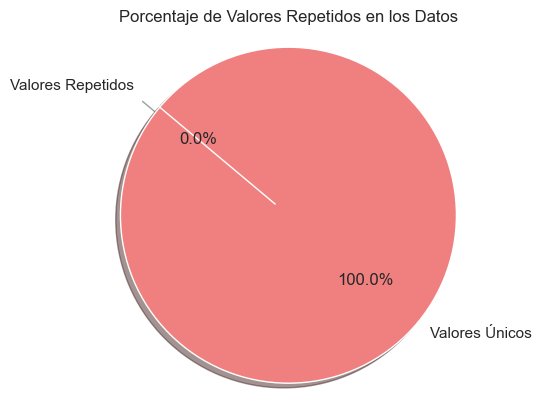

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame llamado 'datos'
# Utiliza la función `duplicated` para marcar filas duplicadas
duplicados = datos[datos.duplicated(keep=False)]

# Luego, utiliza `groupby` para contar cuántas veces se repite cada fila duplicada
conteo_duplicados = duplicados.groupby(list(datos.columns)).size().reset_index(name='Cantidad')

# Filtra las filas que se repiten al menos 2 veces
conteo_duplicados = conteo_duplicados[conteo_duplicados['Cantidad'] >= 2]

# Calcular el porcentaje de valores repetidos
cantidad_filas_duplicadas = len(conteo_duplicados)
total_filas = len(datos)
porcentaje_repetidos = (cantidad_filas_duplicadas / total_filas) * 100

# Crear un gráfico de pastel
labels = ['Valores Únicos', 'Valores Repetidos']
sizes = [100 - porcentaje_repetidos, porcentaje_repetidos]
colors = ['lightcoral', 'lightblue']
explode = (0, 0.1)  # Destacar la porción de valores repetidos

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Asegurar que el gráfico sea un círculo

plt.title('Porcentaje de Valores Repetidos en los Datos')

plt.show()